In [1]:
from google.colab import drive
drive.mount('/amd/')

Mounted at /amd/


In [2]:

!cp /amd/My\ Drive/ODIR-5K_aug.zip /content/

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!unzip ODIR-5K_aug.zip


Streaming output truncated to the last 5000 lines.
  inflating: ODIR-5K/ODIR-5K/Training Images/319_leftVFZM-A.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4310_rightVF-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/499_leftZMRRRB-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4207_rightRR-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1074_leftVF-O.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1272_leftHF-G.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1260_rightRB-G.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1880_leftRB-A.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4592_rightZMRR-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4050_right-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2420_left-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/707_rightVF-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2206_leftRB-C.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1605_rightRR-M.jpg  
  inflating: ODIR-5K/ODIR-5K/Tr

In [7]:
import os
import glob

items_to_remove = []
all_elements_train=0
all_elements_val = 0
for element in glob.glob("ODIR-5K/ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "G.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "G.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)

print(all_elements_train, all_elements_val)

5019 973


In [8]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'C', 'G']

In [9]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [10]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'C':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [11]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  N [1 0 0]
label:  N [1 0 0]
label:  G [0 0 1]
label:  N [1 0 0]
label:  G [0 0 1]
label:  G [0 0 1]


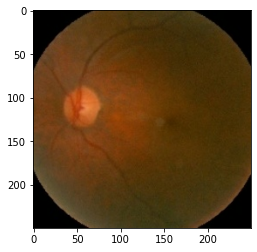

In [12]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [13]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [16]:
# x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
# y = np.array([i[1] for i in dataset])
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

[1 0 0]


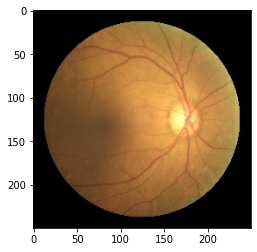

In [19]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [20]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(3, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 32)      96        
_________________________________________________________________
activation (Activation)      (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 32)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 83, 32)        0

In [21]:
 with tf.device('/device:GPU:0'):
                    history_cnn = model_cnn.fit(final_train_ds,
                    #batch_size=32,
                    epochs=12,
                    steps_per_epoch = 150, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 32,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/12
150/150 [==============================] - 108s 455ms/step - loss: 2.8055 - accuracy: 0.4561 - precision: 0.4635 - recall: 0.4416 - val_loss: 3.2288 - val_accuracy: 0.0771 - val_precision: 0.0771 - val_recall: 0.0771
Epoch 2/12
150/150 [==============================] - 66s 440ms/step - loss: 1.0314 - accuracy: 0.6334 - precision: 0.6543 - recall: 0.6112 - val_loss: 3.8563 - val_accuracy: 0.0771 - val_precision: 0.0771 - val_recall: 0.0771
Epoch 3/12
150/150 [==============================] - 66s 443ms/step - loss: 0.8811 - accuracy: 0.6912 - precision: 0.7046 - recall: 0.6707 - val_loss: 1.0620 - val_accuracy: 0.5127 - val_precision: 0.5414 - val_recall: 0.4922
Epoch 4/12
150/150 [==============================] - 66s 439ms/step - loss: 0.8036 - accuracy: 0.7071 - precision: 0.7223 - recall: 0.6934 - val_loss: 1.3724 - val_accuracy: 0.4189 - val_precision: 0.4395 - val_recall: 0.3828
Epoch 5/12
150/150 [==============================] - 66s 443ms/step - loss: 0.7363 - accur

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


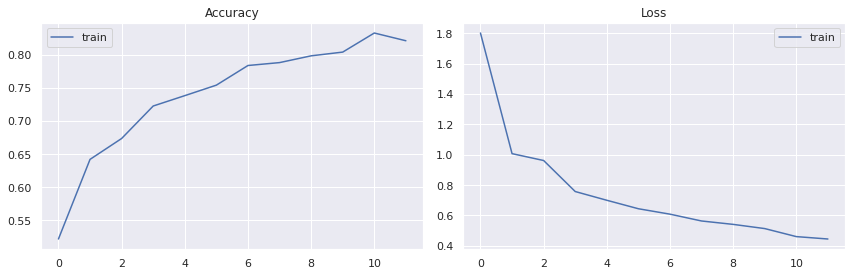

In [22]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history_cnn.epoch,history_cnn.history['accuracy'], label = 'train')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history_cnn.epoch,history_cnn.history['loss'], label = 'train')
plt.title('Loss')
plt.tight_layout()
plt.show()

In [23]:
model_cnn.evaluate(final_test_ds, steps=100)


100/100 [==============================] - 14s 137ms/step - loss: 0.4212 - accuracy: 0.8275 - precision: 0.8419 - recall: 0.8206


[0.4212251901626587,
 0.8274999856948853,
 0.8419365286827087,
 0.8206250071525574]